<a href="https://colab.research.google.com/github/LeticiaVieirg/crack_thermal_detection/blob/main/Unet_CAI_SWTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, log_loss
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from google.colab import drive
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Acess dataset

In [2]:
# Montando o Google Drive para acessar o dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_DIR = '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test'
OUTPUT_DIR = '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/segmented_dataset_unet/'
os.makedirs(os.path.join(OUTPUT_DIR, 'segmentadas_faulty'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'segmentadas_healthy'), exist_ok=True)

Inicialization unet model

In [5]:
# Função para carregar imagens e máscaras
def load_images_and_masks(image_dir, mask_dir=None, target_size=(128, 128)):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
    images = [img_to_array(load_img(img_path, target_size=target_size)) / 255.0 for img_path in image_paths]

    if mask_dir:
        mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
        masks = [img_to_array(load_img(mask_path, target_size=target_size, color_mode='grayscale')) / 255.0 for mask_path in mask_paths]
        return np.array(images), np.array(masks)

    return np.array(images), None

# Diretórios das imagens positivas e negativas
POSITIVE_IMAGE_DIR = os.path.join(DATASET_DIR, 'Faulty')
POSITIVE_MASK_DIR = os.path.join(DATASET_DIR, 'positivas/masks')
NEGATIVE_IMAGE_DIR = os.path.join(DATASET_DIR, 'Healthy')


Load the images and masck

In [6]:
# Definindo o modelo U-Net
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up7 = UpSampling2D(size=(2, 2))(drop4)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, conv9)
    return model

In [7]:
DATASET_DIR = '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test'

# Verifique os diretórios
POSITIVE_IMAGE_DIR = os.path.join(DATASET_DIR, '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Healthy')
POSITIVE_MASK_DIR = os.path.join(DATASET_DIR, '/content/drive/MyDrive/dataset/dataset/segmented_dataset_unet')
NEGATIVE_IMAGE_DIR = os.path.join(DATASET_DIR, '/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty')

# Confirme se os diretórios existem
assert os.path.exists(POSITIVE_IMAGE_DIR), f"Diretório não encontrado: {POSITIVE_IMAGE_DIR}"
assert os.path.exists(POSITIVE_MASK_DIR), f"Diretório não encontrado: {POSITIVE_MASK_DIR}"
assert os.path.exists(NEGATIVE_IMAGE_DIR), f"Diretório não encontrado: {NEGATIVE_IMAGE_DIR}"

# Carregando imagens e máscaras
positive_images, positive_masks = load_images_and_masks(POSITIVE_IMAGE_DIR, POSITIVE_MASK_DIR)
negative_images, _ = load_images_and_masks(NEGATIVE_IMAGE_DIR)

Iniciar treinamento

In [8]:
if positive_masks is None or len(positive_masks) == 0:
    print("Máscaras não carregadas corretamente. Usando máscaras fictícias.")
    positive_masks = np.zeros((len(positive_images), 128, 128, 1))

Máscaras não carregadas corretamente. Usando máscaras fictícias.


In [9]:
print(f"Número de imagens: {len(positive_images)}")
print(f"Número de máscaras: {len(positive_masks)}")

Número de imagens: 600
Número de máscaras: 600


In [10]:
def load_images_and_masks(image_dir, mask_dir=None, target_size=(128, 128)):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
    images = [img_to_array(load_img(img_path, target_size=target_size)) / 255.0 for img_path in image_paths]

    if mask_dir:
        mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
        if len(image_paths) != len(mask_paths):
            raise ValueError(f"Imagens e máscaras não correspondem! Imagens: {len(image_paths)}, Máscaras: {len(mask_paths)}")
        masks = [img_to_array(load_img(mask_path, target_size=target_size, color_mode='grayscale')) / 255.0 for mask_path in mask_paths]
        return np.array(images), np.array(masks)

    return np.array(images), None


In [11]:
#inicializando o modelo u-net
unet=unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = unet.fit(positive_images, positive_masks, validation_split=0.2, epochs=10, batch_size=16)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 769s 25s/step - accuracy: 0.9959 - loss: 0.1255 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 770s 24s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 774s 26s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 794s 25s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 803s 25s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 765s 24s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 720s 24s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 777s 25s/step 

In [12]:
# Função para calcular IoU
def calculate_iou(y_true, y_pred):
    # Converte as predições para binário (threshold = 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)

    # Calcula a interseção e união
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Evita divisão por zero
    if union == 0:
        return 0.0
    else:
        return intersection / union

# Obter predições do modelo nas imagens de validação
y_pred = unet.predict(positive_images)  # Gera predições para as imagens

# Calcular IoU médio
iou_scores = [calculate_iou(positive_masks[i], y_pred[i]) for i in range(len(positive_masks))]
mean_iou = np.mean(iou_scores)

print(f"IoU médio: {mean_iou:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 251s 13s/step
IoU médio: 0.0000


In [13]:
input_directory = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty"
output_directory = "/content/drive/MyDrive/dataset/dataset/segmented_dataset_unet/segmentadas_faulty"
total_images_to_segment = 5  # Número máximo de imagens para segmentação

# Criar diretório de saída se não existir
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Verifica se a pasta de imagens não está vazia
image_files = sorted(os.listdir(input_directory))
if not image_files:
    print(" ERRO: Nenhuma imagem encontrada no diretório de entrada!")
else:
    print(f" {len(image_files)} Images found.")

# Função para segmentação de imagens
def segment_image(image_path, model):
    """
    Realiza a segmentação de uma imagem usando o modelo treinado.

    Args:
        image_path (str): Caminho da imagem de entrada.
        model (keras.Model): Modelo U-Net carregado.

    Returns:
        np.array: Máscara segmentada.
    """
    img = cv2.imread(image_path)

    if img is None:
      print(f" ERRO: Falha ao carregar {image_path}")
      return None

    img = cv2.resize(img, (128, 128))  # Ajuste conforme o input do seu modelo
    img = img / 255.0  # Normalização
    y_pred = model.predict(np.expand_dims(img, axis=0))  # Predição
    return y_pred[0]

# Processamento das imagens
image_files = sorted(os.listdir(input_directory))

for i, image_name in enumerate(image_files):
    if i >= total_images_to_segment:
        break

    image_path = os.path.join(input_directory, image_name)

    if os.path.exists(image_path):
        pred_mask = segment_image(image_path, unet)  # Chama a segmentação

        if pred_mask is not None:  # Só salva se a predição for válida
            mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255
            mask_name = f'{image_name.split(".")[0]}_mask.jpg'
            mask_path = os.path.join(output_directory, mask_name)
            cv2.imwrite(mask_path, mask_binary)
            print(f" Save segmented: {mask_path}")


 601 Images found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
 Save segmented: /content/drive/MyDrive/dataset/dataset/segmented_dataset_unet/segmentadas_faulty/Areial_Faulty1_mask.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
 Save segmented: /content/drive/MyDrive/dataset/dataset/segmented_dataset_unet/segmentadas_faulty/Areial_Faulty100_mask.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
 Save segmented: /content/drive/MyDrive/dataset/dataset/segmented_dataset_unet/segmentadas_faulty/Areial_Faulty105_mask.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
 Save segmented: /content/drive/MyDrive/dataset/dataset/segmented_dataset_unet/segmentadas_faulty/Areial_Faulty109_mask.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
 Save segmented: /content/drive/MyDrive/dataset/dataset/segmented_dataset_unet/segmentadas_faulty/Areial_Faulty11_mask.jpg


 ERRO: Imagem /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty/FLIR1815.jpg não encontrada!
 ERRO: Imagem /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty/FLIR1816.jpg não encontrada!
 ERRO: Imagem /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty/FLIR1817.jpg não encontrada!
 ERRO: Imagem /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty/FLIR1818.jpg não encontrada!


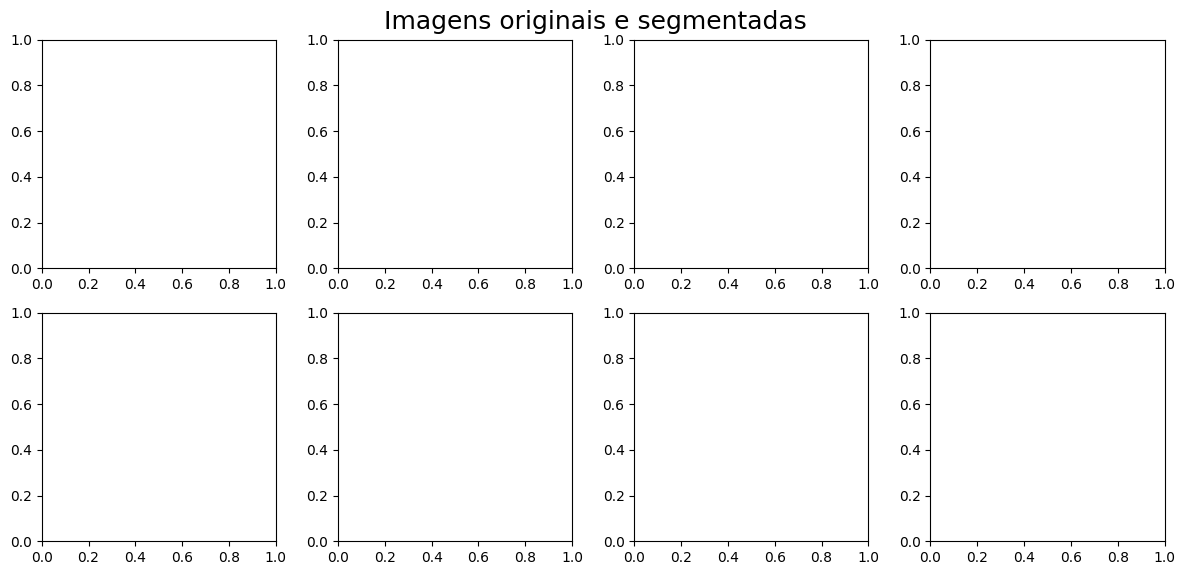

In [14]:

# Definir parâmetros
n = 4  # Número de imagens para exibição
input_folder = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty"
output_folder = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/segmented_dataset_unet/segmentadas_faulty"

# Criar a figura
fig, axs = plt.subplots(2, n, figsize=(12, 6))
fig.suptitle('Imagens originais e segmentadas', fontsize=18, y=0.95)

for i in range(n):
    img_path = os.path.join(input_folder, f'FLIR181{i+5}.jpg')

    # Verificar se a imagem original existe
    if not os.path.exists(img_path):
        print(f" ERRO: Imagem {img_path} não encontrada!")
        continue

    # Carregar e converter a imagem
    image = cv2.imread(img_path)
    if image is None:
        print(f" ERRO ao carregar {img_path}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Redimensionar para manter o desempenho
    image_resized = cv2.resize(image, (image.shape[1]//1, image.shape[0]//1))

    # Converter para formato adequado para clustering
    image_data = image_resized.reshape((-1, 3))

    # Aplicar K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=256, n_init=10)
    kmeans.fit(image_data)

    # Criar a máscara binária
    mask = kmeans.labels_.reshape(image_resized.shape[:2])

    # Exibir imagem original
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

    # Exibir máscara segmentada
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [15]:

import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [16]:

input_folder = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty"
output_folder = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/segmented_dataset_unet/segmentadas_faulty"

# Criar a pasta de saída se não existir
os.makedirs(output_folder, exist_ok=True)

# Processar todas as imagens na pasta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imagens
        image_path = os.path.join(input_folder, filename)

        # Carregar imagem
        image = cv2.imread(image_path)
        if image is None:
            continue  # Ignorar arquivos inválidos

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Redimensionar para manter o desempenho
        image_resized = cv2.resize(image, (image.shape[1] // 1, image.shape[0] // 1))

        # Converter para o formato adequado para clustering
        image_data = image_resized.reshape((-1, 3))

        # Aplicar K-means clustering
        kmeans = KMeans(n_clusters=2, random_state=256, n_init=10)
        kmeans.fit(image_data)

        # Criar a máscara binária
        mask = kmeans.labels_.reshape(image_resized.shape[:2])

        # Salvar a máscara como imagem
        output_path = os.path.join(output_folder, f"segmented_{filename}")
        cv2.imwrite(output_path, (mask * 255).astype(np.uint8))

print("Processamento concluído! As imagens segmentadas foram salvas.")

Processamento concluído! As imagens segmentadas foram salvas.


Segmentacao em uma imagem

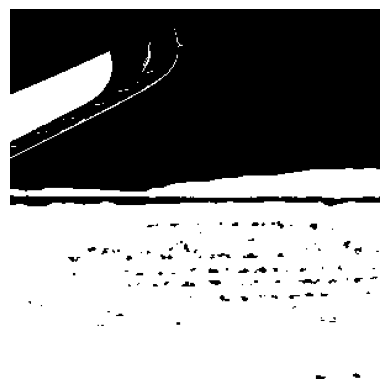

In [17]:
image = cv2.imread ('/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Faulty/Areial_Faulty1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Redimensionar a imagem para reduzir a carga computacional
image_resized = cv2.resize(image, (image.shape[1]//1, image.shape[0]//1))

# Converter a imagem para o formato de dados para clustering
image_data = image_resized.reshape((-1, 3))

# Aplicar K-means clustering
kmeans = KMeans(n_clusters=2, random_state=(256))
kmeans.fit(image_data)

# Criar a máscara binária
mask = kmeans.labels_.reshape(image_resized.shape[:2])

# Exibir a máscara
plt.imshow(mask, cmap='gray')  # Exibe em escala de cinza
plt.axis('off')  # Remove os eixos para melhor visualização
plt.show()